# Text Clustering with Sentence-BERT

In [23]:
!pip3 install sentence-transformers

In [24]:
!pip install datasets

In [25]:
import pandas as pd, numpy as np
import torch, os
from datasets import load_dataset

In [26]:
dataset = load_dataset("amazon_polarity",split="train")

Reusing dataset amazon_polarity (/root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/ac31acedf6cda6bc2aa50d448f48bbad69a3dd8efc607d2ff1a9e65c2476b4c1)


In [27]:
dataset

Dataset({
    features: ['content', 'label', 'title'],
    num_rows: 3600000
})

In [28]:
corpus=dataset.shuffle(seed=42)[:10000]['content']

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/ac31acedf6cda6bc2aa50d448f48bbad69a3dd8efc607d2ff1a9e65c2476b4c1/cache-ef801afe8232c47a.arrow


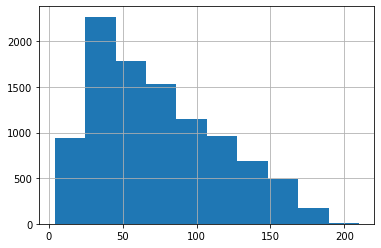

In [29]:
pd.Series([len(e.split()) for e in corpus]).hist()

## Model Selection
(source link: https://www.sbert.net/docs/pretrained_models.html)
The best available models for STS are:

* stsb-mpnet-base-v2
* stsb-roberta-base-v2
* stsb-distilroberta-base-v2
* nli-mpnet-base-v2
* nli-roberta-base-v2 
* nli-distilroberta-base-v2

Paraphrase Identification Models
* paraphrase-distilroberta-base-v1 - Trained on large scale paraphrase data.
* paraphrase-xlm-r-multilingual-v1 - Multilingual version of paraphrase-distilroberta-base-v1, trained on parallel data for 50+ languages. (Teacher: paraphrase-distilroberta-base-v1, Student: xlm-r-base)

In [30]:
from sentence_transformers import SentenceTransformer
model_path="paraphrase-distilroberta-base-v1"
#paraphrase-distilroberta-base-v1 - Trained on large scale paraphrase data.
model = SentenceTransformer(model_path)

In [31]:
corpus_embeddings = model.encode(corpus)
corpus_embeddings.shape

(10000, 768)

In [32]:
from sklearn.cluster import KMeans
K=5
kmeans = KMeans(n_clusters=5, random_state=0).fit(corpus_embeddings)

In [33]:
import pandas as pd
cls_dist=pd.Series(kmeans.labels_).value_counts()
cls_dist

3    2772
4    2089
0    1911
2    1883
1    1345
dtype: int64

In [34]:
import scipy
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_ , corpus_embeddings)

In [35]:
centers={}
print("Cluster", "Size", "Center-idx", "Center-Example", sep="\t\t")
for i,d in enumerate(distances):
  ind = np.argsort(d, axis=0)[0]
  centers[i]=ind
  print(i,cls_dist[i], ind, corpus[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		1911		5536		The sound quality is not good. I used it once and couldn't take the poor audio. I bought this because the cheaper one I bought previously had poor sound quality, but this more expensive one is no better. Save your money for a radio that comes outfitted with the proper connectors.
1		1345		3900		This album like many rock/emo albums is good, but there is nothing innovative about it, some very catchy tunes, good singing, nice rhythm. Awesome to listen to. Worth the buy.
2		1883		204		This DVD looks nice and all but is horrible because it skips and stuff after the first time I watched it. Thumbs down.
3		2772		1761		I read this book a while back and thought it was very interesting. It's a good book to read if your tired of just reading love stories all the time.
4		2089		1474		The quality of this product is great, easy to clean and fits my sink perfectly.However, I think it is a little bit expensive.


## Visualization of the cluster points

In [36]:
!pip install umap-learn

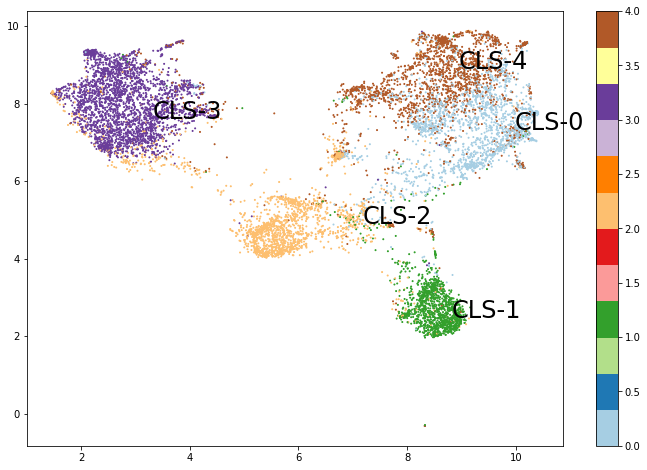

In [37]:
import matplotlib.pyplot as plt
import umap
X = umap.UMAP(n_components=2, min_dist=0.0).fit_transform(corpus_embeddings)
labels= kmeans.labels_

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
  plt.text(X[centers[c],0], X[centers[c], 1], "CLS-"+ str(c), fontsize=24) 
plt.colorbar()

## Topic Modeling with BERT

BERTopic Official NOTE: BERTopic is stocastich which means that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

In [38]:
!pip install bertopic

Official Note: Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

In [40]:
len(corpus)

10000

In [41]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("paraphrase-distilroberta-base-v1")
topic_model = BERTopic(embedding_model=sentence_model)
topics, _ = topic_model.fit_transform(corpus)

In [42]:
topic_model.get_topic_info()[:6]

,Topic,Count,Name
0,-1,3119,-1_book_read_books_his
1,0,2041,0_my_product_not_had
2,1,1495,1_movie_film_dvd_watch
3,2,1306,2_album_cd_songs_music
4,3,239,3_game_games_play_graphics
5,4,143,4_hair_products_skin_used


In [44]:
topic_model.get_topic(2)

[('album', 0.022458465897699162),
 ('cd', 0.022357671269330873),
 ('songs', 0.0160285876024971),
 ('music', 0.015663871869609634),
 ('song', 0.013265783250597301),
 ('band', 0.008915803010910899),
 ('sound', 0.007935450670483247),
 ('great', 0.007270445913487295),
 ('good', 0.006867072444449145),
 ('albums', 0.00664840595331807)]